In [1]:
import dynalearn
import pickle
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import tqdm
import os

In [2]:
def chain_graph(n):
    g = nx.Graph()
    g.add_node(0)
    for i in range(1, n):
        g.add_node(i)
        g.add_edge(i - 1, i)
    g.name = 'chain_n{0}'.format(n)
    return g

def complete_graph(n):
    g = nx.complete_graph(n)
    g.name = 'complete_n{0}'.format(n)
    return g

def star_graph(n):
    g = nx.Graph()
    g.add_node(0)
    for i in range(1, n):
        g.add_edge(0, i)
    g.name = 'star_n{0}'.format(n)
    return g

def regular_graph(n, d):
    g = nx.random_regular_graph(d, n)
    g.name = 'regular_n{0}_d{1}'.format(n, d)
    return g

def empty_graph(n):
    g = nx.empty_graph(n)
    g.name = 'empty_n{0}'.format(n)
    return g

def BA_tree_graph(n):
    g = nx.barabasi_albert_graph(n, 1)
    g.name = 'ba_tree_n{0}'.format(n)
    return g

def ER_graph(n, p):
    g = nx.gnp_random_graph(n, p)
    g.name = 'er_n{0}_p{1}'.format(n, p)
    return g

In [4]:
# Generating the network
n_nodes = 10
inf_prob = 0.1
rec_prob = 0.08
T = 100
batch_size = None

train_sample = 20000
val_sample = 1000

approach = "gatpred"
graph = complete_graph(n_nodes)
# graph = chain_graph(n_nodes)
# graph = empty_graph(n_nodes)
# graph = star_graph(n_nodes)
# graph = BA_tree_graph(n_nodes)
# graph = ER_graph(n_nodes, 0.5)

f_prefix = 'data/' + approach + "_" + graph.name + "_SIS_inf{0}_rec{1}".format(inf_prob, rec_prob)
if not os.path.exists(f_prefix):
    os.mkdir(f_prefix)


train_generator = dynalearn.datasets.SISGenerator(graph, inf_prob, rec_prob, batch_size,
                                                  online=False, init_active=None,
                                                  shuffle=True, with_structure=True)
val_generator = dynalearn.datasets.SISGenerator(graph, inf_prob, rec_prob, batch_size,
                                                online=False, init_active=None,
                                                shuffle=False, with_structure=True)
test_generator = dynalearn.datasets.SISGenerator(graph, inf_prob, rec_prob, batch_size,
                                                online=False, init_active=None,
                                                shuffle=False, with_structure=True)
train_generator.generate(train_sample, T, tqdm.tqdm_notebook)
val_generator.generate(val_sample, T, tqdm.tqdm_notebook)
test_generator.generate(val_sample, T, tqdm.tqdm_notebook)

In [5]:
for name, p in model.named_parameters():
    print(name, p.size())

NameError: name 'model' is not defined

In [6]:
from __future__ import absolute_import

from tensorflow.keras import activations, constraints, initializers, regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer, Dropout, LeakyReLU


class GraphAttention(Layer):

    def __init__(self,
                 F_,
                 attn_heads=1,
                 attn_heads_reduction='concat',  # {'concat', 'average'}
                 dropout_rate=0.5,
                 activation='relu',
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 attn_kernel_initializer='glorot_uniform',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 attn_kernel_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 attn_kernel_constraint=None,
                 **kwargs):
        if attn_heads_reduction not in {'concat', 'average'}:
            raise ValueError('Possbile reduction methods: concat, average')

        self.F_ = F_  # Number of output features (F' in the paper)
        self.attn_heads = attn_heads  # Number of attention heads (K in the paper)
        self.attn_heads_reduction = attn_heads_reduction  # Eq. 5 and 6 in the paper
        self.dropout_rate = dropout_rate  # Internal dropout rate
        self.activation = activations.get(activation)  # Eq. 4 in the paper
        self.use_bias = use_bias

        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)
        self.attn_kernel_initializer = initializers.get(attn_kernel_initializer)

        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)
        self.attn_kernel_regularizer = regularizers.get(attn_kernel_regularizer)
        self.activity_regularizer = regularizers.get(activity_regularizer)

        self.kernel_constraint = constraints.get(kernel_constraint)
        self.bias_constraint = constraints.get(bias_constraint)
        self.attn_kernel_constraint = constraints.get(attn_kernel_constraint)
        self.supports_masking = False

        # Populated by build()
        self.kernels = []       # Layer kernels for attention heads
        self.biases = []        # Layer biases for attention heads
        self.attn_kernels = []  # Attention kernels for attention heads

        if attn_heads_reduction == 'concat':
            # Output will have shape (..., K * F')
            self.output_dim = self.F_ * self.attn_heads
        else:
            # Output will have shape (..., F')
            self.output_dim = self.F_

        super(GraphAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) >= 2
        F = int(input_shape[0][-1])

        # Initialize weights for each attention head
        for head in range(self.attn_heads):
            # Layer kernel
            kernel = self.add_weight(shape=(F, int(self.F_)),
                                     initializer=self.kernel_initializer,
                                     regularizer=self.kernel_regularizer,
                                     constraint=self.kernel_constraint,
                                     name='kernel_{}'.format(head))
            self.kernels.append(kernel)

            # # Layer bias
            if self.use_bias:
                bias = self.add_weight(shape=(int(self.F_), ),
                                       initializer=self.bias_initializer,
                                       regularizer=self.bias_regularizer,
                                       constraint=self.bias_constraint,
                                       name='bias_{}'.format(head))
                self.biases.append(bias)

            # Attention kernels
            attn_kernel_self = self.add_weight(shape=(int(self.F_), 1),
                                               initializer=self.attn_kernel_initializer,
                                               regularizer=self.attn_kernel_regularizer,
                                               constraint=self.attn_kernel_constraint,
                                               name='attn_kernel_self_{}'.format(head),)
            attn_kernel_neighs = self.add_weight(shape=(int(self.F_), 1),
                                                 initializer=self.attn_kernel_initializer,
                                                 regularizer=self.attn_kernel_regularizer,
                                                 constraint=self.attn_kernel_constraint,
                                                 name='attn_kernel_neigh_{}'.format(head))
            self.attn_kernels.append([attn_kernel_self, attn_kernel_neighs])
        self.built = True

    def call(self, inputs):
        X = inputs[0]  # Node features (N x F)
        A = inputs[1]  # Adjacency matrix (N x N)

        outputs = []
        for head in range(self.attn_heads):
            kernel = self.kernels[head]  # W in the paper (F x F')
            attention_kernel = self.attn_kernels[head]  # Attention kernel a in the paper (2F' x 1)

            # Compute inputs to attention network
            features = K.dot(X, kernel)  # (N x F')

            # Compute feature combinations
            # Note: [[a_1], [a_2]]^T [[Wh_i], [Wh_2]] = [a_1]^T [Wh_i] + [a_2]^T [Wh_j]
            attn_for_self = K.dot(features, attention_kernel[0])    # (N x 1), [a_1]^T [Wh_i]
            attn_for_neighs = K.dot(features, attention_kernel[1])  # (N x 1), [a_2]^T [Wh_j]

            # Attention head a(Wh_i, Wh_j) = a^T [[Wh_i], [Wh_j]]
            dense = attn_for_self + K.transpose(attn_for_neighs)  # (N x N) via broadcasting

            # Add nonlinearty
            dense = LeakyReLU(alpha=0.2)(dense)

            # Mask values before activation (Vaswani et al., 2017)
            mask = -10e9 * (1.0 - A)
            dense += mask

            # Apply softmax to get attention coefficients
            dense = K.softmax(dense)  # (N x N)

            # Apply dropout to features and attention coefficients
            dropout_attn = Dropout(self.dropout_rate)(dense)  # (N x N)
            dropout_feat = Dropout(self.dropout_rate)(features)  # (N x F')

            # Linear combination with neighbors' features
            node_features = K.dot(dropout_attn, dropout_feat)  # (N x F')
            node_features = node_features + dropout_feat # skip connection
            

            if self.use_bias:
                node_features = K.bias_add(node_features, self.biases[head])

            # Add output of attention head to final output
            outputs.append(node_features)

        # Aggregate the heads' output according to the reduction method
        if self.attn_heads_reduction == 'concat':
            output = K.concatenate(outputs)  # (N x KF')
        else:
            output = K.mean(K.stack(outputs), axis=0)  # N x F')

        output = self.activation(output)
        return output

    def compute_output_shape(self, input_shape):
        output_shape = input_shape[0][0], self.output_dim
        return output_shape


In [7]:
import numpy as np
from tensorflow.keras.layers import Input, Dense, Softmax, Dense, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

from dynalearn.keras_models.base import MarkovPredictor


class GATMarkovPredictor(MarkovPredictor):
    def __init__(self, graph, n_hidden, n_heads,
                 weight_decay=1e-4, dropout=0.6, **kwargs):
        if type(n_hidden) is int:
            n_hidden = [n_hidden]
        if type(n_heads) is int:
            n_heads = [n_heads] * len(n_hidden)
        elif len(n_heads) != len(n_hidden):
            raise ValueError
        
        self.graph = graph
        self.n_nodes = graph.number_of_nodes()
        self.n_hidden = n_hidden
        self.n_heads = n_heads
        self.weight_decay = weight_decay
        self.dropout = dropout
        super(GATMarkovPredictor, self).__init__(**kwargs)


    def get_model(self):
        N = self.graph.number_of_nodes()
        inputs = Input(shape=(1, ))
        adj = Input(shape=(N, ))

        x = inputs
        for i in range(len(self.n_hidden)):
            att = GraphAttention(self.n_hidden[i],
                                 attn_heads=self.n_heads[i],
                                 attn_heads_reduction='concat',  # {'concat', 'average'}
                                 dropout_rate=0.5,
                                 activation='linear',
                                 kernel_regularizer=l2(self.weight_decay))
            x = att([x, adj])

        outputs = Sigmoid(x)

        return Model([inputs, adj], outputs=outputs)

New best Epoch: 0 - Time: 0.00
	 Train. - loss: 0.6996, 
New best Epoch: 1 - Time: 0.03, lr: 0.001
	 Train. - loss: 0.6995, 
New best Epoch: 2 - Time: 0.01, lr: 0.001
	 Train. - loss: 0.6988, 
Epoch: 3 - Time: 0.00, lr: 0.001
Epoch: 4 - Time: 0.00, lr: 0.001
Epoch: 5 - Time: 0.00, lr: 0.001
Epoch: 6 - Time: 0.00, lr: 0.001
Epoch: 7 - Time: 0.00, lr: 0.001
Epoch: 8 - Time: 0.00, lr: 0.001
Epoch: 9 - Time: 0.00, lr: 0.0002
Epoch: 10 - Time: 0.00, lr: 0.0002
Epoch: 11 - Time: 0.00, lr: 0.0002
Epoch: 12 - Time: 0.00, lr: 0.0002
Epoch: 13 - Time: 0.00, lr: 0.0002
Epoch: 14 - Time: 0.00, lr: 0.0002
Epoch: 15 - Time: 0.00, lr: 4e-05
Epoch: 16 - Time: 0.00, lr: 4e-05
Epoch: 17 - Time: 0.00, lr: 4e-05
Epoch: 18 - Time: 0.00, lr: 4e-05
Epoch: 19 - Time: 0.01, lr: 4e-05
Epoch: 20 - Time: 0.00, lr: 4e-05
Epoch: 21 - Time: 0.00, lr: 8.000000000000001e-06
Epoch: 22 - Time: 0.00, lr: 8.000000000000001e-06
Epoch: 23 - Time: 0.00, lr: 8.000000000000001e-06
Epoch: 24 - Time: 0.00, lr: 8.000000000000001e

In [8]:
model.save_state(f_prefix)

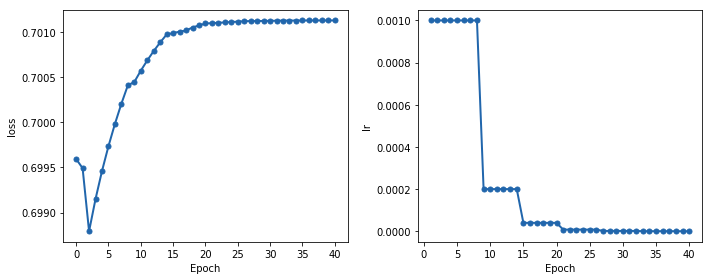

In [9]:
fig, ax = plt.subplots(1, 2,figsize=(10, 4))
_ax = {}
metrics = ['loss', 'lr']
for i, m in enumerate(metrics):
#     ax[i].set_xscale('log')
#     ax[i].set_yscale('log')
    _ax[m] = ax[i]

model.history.plot(training_metrics = ['loss'], model_metrics=['lr'],ax=(fig,_ax))
plt.tight_layout()

fig.savefig(os.path.join(f_prefix, 'training.png'))
plt.show()

In [10]:
x, adj, y = train_dataset[0]
adj = train_dataset.adjacency.view(1, n_nodes, n_nodes)
y_ = model.predict(y.view(1, n_nodes, 1), adj, batch_size=1)
xx = x.view(n_nodes)
xx[xx==-1] = 0
print('x :', xx)
print('y :', y.view(n_nodes)) 
print('pred :', y_.view(n_nodes))

x : tensor([0., 1., 0., 0., 0., 0., 0., 1., 0., 0.])
y : tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])
pred : tensor([0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.6385, 0.5000,
        0.5000])


In [38]:
def get_transitionProb(graph, model, dataset, epsilon=None):
    all_states = dataset.enumerate_all_states(graph)
    
    realTransProb = np.zeros([len(all_states), len(all_states)])
    learnedTransProb = np.zeros([len(all_states), len(all_states)])
    bar = tqdm.tqdm_notebook(range(len(all_states)), desc='Evaluation')
    adj = dataset.adjacency.view(1, n_nodes, n_nodes)
    for j, past in enumerate(all_states):
        bar.update()
        _past = torch.tensor(past).float()
        _past = _past.view(1, n_nodes, 1)

        realProb = dataset.get_transition_probability(graph, past)
        learnedProb = model.predict(_past, dataset.adjacency, batch_size=1).numpy()
        
        
        for i, present in enumerate(all_states):
            present_real_prob = present * realProb + (1 - present) * (1 - realProb)
            present_learned_prob = present * learnedProb + (1 - present) * (1 - learnedProb)
            realTransProb[i, j] = np.prod(present_real_prob)
            learnedTransProb[i, j] = np.prod(present_learned_prob)
    
    if epsilon:
        realTransProb[realTransProb == 0] = epsilon
        learnedTransProb[learnedTransProb == 0] = epsilon
    
    for i in range(len(all_states)):
        if realTransProb[:, i].sum() > epsilon * len(all_states) * 2:
            realTransProb[:, i] /= realTransProb[:, i].sum()
        
        if learnedTransProb[:, i].sum() > epsilon * len(all_states) * 2:
            learnedTransProb[:, i] /= learnedTransProb[:, i].sum()
    
    return realTransProb, learnedTransProb


def bit_to_value(array):
    d = array.shape
    bit = 2**np.arange(d)
    return np.sum(array * bit)

def bit_to_value_torch(array):
    d = array.size(0)
    bit = 2**torch.arange(d, dtype=array.dtype)
    return int(torch.sum(array * bit))
    

def get_transitionOccurence(graph, dataset, epsilon=None):
    all_states = dataset.enumerate_all_states(graph)
    n = graph.number_of_nodes()
    occurence = np.zeros([2**n, 2**n])
    bar = tqdm.tqdm_notebook(range(len(dataset)), desc='Occurence')
    
    for i in range(len(dataset)):
        bar.update()
        inputs, adj, targets = dataset[i]
        inputs = inputs.clone().squeeze()
        targets = targets.clone().squeeze()
        i, j = bit_to_value_torch(targets), bit_to_value_torch(inputs)
        
        occurence[i, j] += 1
    
    if epsilon:
        occurence[occurence == 0] = epsilon
    
    return occurence / np.sum(occurence)
    
    
    
        

In [32]:
realTransProb, learnedTransProb = get_transitionProb(graph, model, train_dataset, epsilon=1e-50)
occurence = get_transitionOccurence(graph, train_dataset, epsilon=1e-50)

np.savetxt(os.path.join(f_prefix, "real_transition_prob.txt"), realTransProb)
np.savetxt(os.path.join(f_prefix, "learned_transition_prob.txt"), learnedTransProb)
np.savetxt(os.path.join(f_prefix, "config_occurence.txt"), occurence)

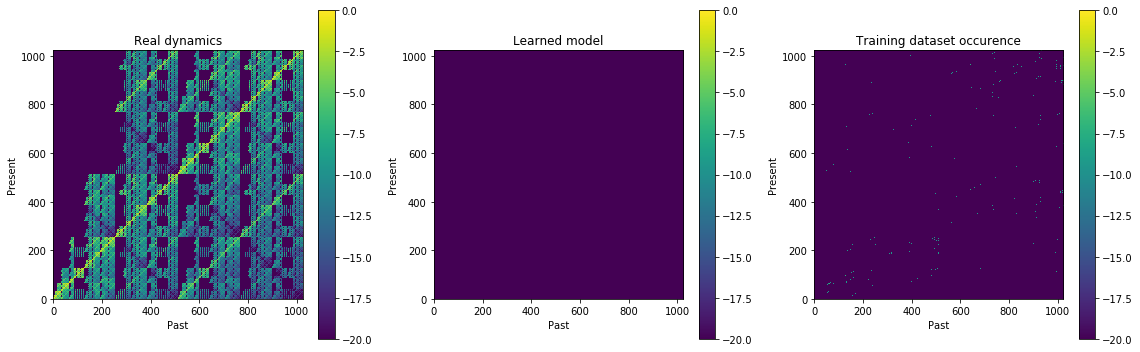

In [33]:
fig, ax = plt.subplots(1, 3, figsize=(16, 5))

cs = ax[0].imshow(np.log(realTransProb), origin='lower', vmin=-20, vmax=0)
# ax[0].xaxis.tick_top()
ax[0].set_xlabel('Past')
ax[0].set_ylabel('Present')
ax[0].set_title('Real dynamics')
plt.colorbar(cs, ax=ax[0])

ax[1].imshow(np.log(learnedTransProb), origin='lower', vmin=-20, vmax=0)
# ax[1].xaxis.tick_top()
ax[1].set_xlabel('Past')
ax[1].set_ylabel('Present')
ax[1].set_title('Learned model')
plt.colorbar(cs, ax=ax[1])

cs = ax[2].imshow(np.log(occurence), origin='lower', vmin=-20, vmax=0)
ax[2].set_xlabel('Past')
ax[2].set_ylabel('Present')
ax[2].set_title('Training dataset occurence')
plt.colorbar(cs, ax=ax[2])
plt.tight_layout()

fig.savefig(os.path.join(f_prefix, "transition_prob.png"))

plt.show()

In [ ]:
n, m = occurence.shape
data_real = []
data_learned = []
notdata_real = []
notdata_learned = []


for i in range(n):
    for j in range(n):    
        if occurence[i, j] > 1e-15:
            data_real.append(realTransProb[i, j])
            data_learned.append(learnedTransProb[i, j])
        else:
            notdata_real.append(realTransProb[i, j])
            notdata_learned.append(learnedTransProb[i, j])
            

In [ ]:
plt.plot(notdata_real, notdata_learned, '.', label='Not in training dataset')
plt.plot(data_real, data_learned, '.', label='In training dataset')
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100), c='grey', ls='--')
plt.xlabel('Real')
plt.ylabel('Learned')
plt.xscale('log')
plt.yscale('log')
plt.xlim([1e-16, 0])
plt.ylim([1e-16, 0])
plt.legend()
plt.savefig('./testing_probability_20epoch.png')
plt.show()